In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, RocCurveDisplay

## 1. Reading data

In [2]:
data = pd.read_csv("mushroom.csv")
X, y = data.drop('class', axis=1).copy(), data['class'].copy()
data.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,...,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,...,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,...,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,...,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,...,s,y,w,u,w,t,p,NaN,d,w


In [3]:
#по умолчанию describe делается по числовым колонкам
data.describe()

,cap-diameter,stem-height,stem-width
count,61069.000000,61069.000000,61069.000000
mean,6.733854,6.581538,12.149410
std,5.264845,3.370017,10.035955
min,0.380000,0.000000,0.000000
25%,3.480000,4.640000,5.210000
50%,5.860000,5.950000,10.190000
75%,8.540000,7.740000,16.570000
max,62.340000,33.920000,103.910000


In [4]:
#describe по не числовым колонкам
data.describe(exclude=[np.number])

,class,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
count,61069,61069,46949,61069,61069,51185,36006,61069,9531,22945,61069,3177,7413,61069,58598,6354,61069,61069
unique,2,7,11,12,2,7,3,12,5,8,13,1,6,2,8,7,8,4
top,p,x,t,n,f,a,c,w,s,s,w,u,w,f,f,k,d,a
freq,33888,26934,8196,24218,50479,12698,24710,18521,3177,6025,22926,3177,5474,45890,48361,2118,44209,30177


In [5]:
NaN_percent = X.isnull().sum(axis=0) / len(X) * 100 # % NaN
print(NaN_percent)
#баланс классов
print('-'*20)
print(y.describe())
print({k:(y == k).mean() for k in y.unique()})

cap-diameter             0.000000
cap-shape                0.000000
cap-surface             23.121387
cap-color                0.000000
does-bruise-or-bleed     0.000000
gill-attachment         16.184971
gill-spacing            41.040462
gill-color               0.000000
stem-height              0.000000
stem-width               0.000000
stem-root               84.393064
stem-surface            62.427746
stem-color               0.000000
veil-type               94.797688
veil-color              87.861272
has-ring                 0.000000
ring-type                4.046243
spore-print-color       89.595376
habitat                  0.000000
season                   0.000000
dtype: float64
--------------------
count     61069
unique        2
top           p
freq      33888
Name: class, dtype: object
{'p': 0.5549132947976878, 'e': 0.44508670520231214}


* Существует проблема, что есть признаки, у которых  большое количество пропусков, поэтому для некоторых моделей это может стать проблемой

  Так как я не разбираюсь в грибах принимаю решение избавиться от тех признаков, что содержат много пропусков, а там где пропусков мало заполним модой

* Классы выглядят сбалансированными

In [6]:
data = data.drop(columns=NaN_percent[NaN_percent > 20].index) #удалим столбцы, в которых >20% значений пропущено

In [7]:
data.fillna(data.mode().to_numpy, inplace=True)

In [8]:
#y transformation
LE = LabelEncoder().fit(y)
y = LE.transform(y)

In [9]:
#x transformation
categorical_columns = X.select_dtypes(exclude = [np.number]).columns.to_list()

for col in categorical_columns:
    oh = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
    one_hot_encoded = oh.fit_transform(X[[col]])
    X = pd.concat([X,one_hot_encoded],axis=1).drop(columns=[col])

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## 2. Training models

In [11]:
models_dict = {}

#### 2.1 OneRule

In [12]:
from mlxtend.classifier import OneRClassifier

In [13]:
OneR = OneRClassifier().fit(X_train.to_numpy(), y_train)
y_pred = OneR.predict(X_test.to_numpy())
print(f'Accuracy: {(y_pred == y_test).mean()}')

Accuracy: 0.6004584902570821


In [14]:
models_dict['OneR'] = OneR

#### 2.2 LogisticRegression

In [15]:
from sklearn.linear_model import LogisticRegression

In [16]:
LogReg = LogisticRegression(max_iter=2000).fit(X_train, y_train)
print(
f'''Accuracy: {LogReg.score(X_test, y_test)}
roc_auc score {roc_auc_score(y_test, LogReg.predict_proba(X_test)[:, 1])}'''
)#Разберись что пихают в рок аук

Accuracy: 0.8617979367938431
roc_auc score 0.9356554230059786


In [17]:
models_dict['LogReg'] = LogReg

#### 2.3 KNN

In [18]:
from sklearn.neighbors import KNeighborsClassifier

In [19]:
KNN = KNeighborsClassifier().fit(X_train, y_train)
print(
f'''Accuracy: {KNN.score(X_test, y_test)}
roc_auc score {roc_auc_score(y_test, KNN.predict_proba(X_test)[:, 1])}'''
)

Accuracy: 0.9993995960919164
roc_auc score 0.9999500329271593


In [20]:
models_dict['KNN'] = KNN

#### 2.4 Bayes Classifier

In [21]:
from sklearn.naive_bayes import CategoricalNB

In [22]:
MrBayes = CategoricalNB().fit(X_train, y_train)
print(
f'''Accuracy: {MrBayes.score(X_test, y_test)}
roc_auc score {roc_auc_score(y_test, MrBayes.predict_proba(X_test)[:, 1])}'''
)
#что-то с фичами не так, нужен фикс

Accuracy: 0.7824900387533431
roc_auc score 0.8775959800351126


In [23]:
models_dict['Bayes'] = MrBayes

#### 2.5 DescisionTree

In [24]:
from sklearn.tree import DecisionTreeClassifier

In [25]:
tree = DecisionTreeClassifier().fit(X_train, y_train)
print(
f'''train acc {(tree.predict(X_train) == y_train).mean()}
test acc {(tree.predict(X_test) == y_test).mean()}
'''
)

train acc 1.0
test acc 0.9996179247857649



In [26]:
models_dict['tree'] = tree

#### 2.6 Boosting

In [27]:
from catboost import CatBoostClassifier, Pool

In [32]:
test_pool = Pool(X_test, y_test)

boosting = CatBoostClassifier(iterations=500,
                           depth=3,
                           learning_rate=0.001,
                           loss_function='Logloss',
                           task_type='GPU',
                           verbose=False)
# train the model
boosting.fit(X_train, y_train)
# make the prediction using the resulting model
preds_class = boosting.predict(test_pool)
preds_proba = boosting.predict_proba(test_pool)
score = boosting.score(test_pool)
print("class = ", preds_class)
print("proba = ", preds_proba)
print("score = ", score)

class =  [1 0 1 ... 1 0 1]
proba =  [[0.43948096 0.56051904]
 [0.52298343 0.47701657]
 [0.40282319 0.59717681]
 ...
 [0.41148401 0.58851599]
 [0.51792808 0.48207192]
 [0.44166711 0.55833289]]
score =  0.7709186179793679


In [33]:
models_dict['CatBoost'] = boosting

#### 2.7 SVC

In [34]:
from sklearn.svm import SVC

In [36]:
vector_classif = SVC().fit(X_train, y_train)
print(
f'''Accuracy: {vector_classif.score(X_test, y_test)}'''
)

Accuracy: 0.9597183559849353


In [37]:
models_dict['SVM'] = vector_classif

#### 2.8 MLP

In [38]:
from sklearn.neural_network import MLPClassifier

In [39]:
MLP = MLPClassifier().fit(X_train, y_train)
print(
f'''Accuracy: {MLP.score(X_test, y_test)}
roc_auc score {roc_auc_score(y_test, MLP.predict_proba(X_test)[:, 1])}'''
)

Accuracy: 1.0
roc_auc score 1.0


In [40]:
models_dict['MLP'] = MLP

#### 2.9 Ensemble

In [41]:
from sklearn.ensemble import RandomForestClassifier

In [42]:
forest = RandomForestClassifier(n_estimators=50, 
                                criterion='entropy', 
                                max_depth=30)
forest.fit(X_train, y_train)
print(
f'''train acc {(forest.predict(X_train) == y_train).mean()}
test acc {(forest.predict(X_test) == y_test).mean()}'''
)

train acc 1.0
test acc 1.0


In [43]:
models_dict['RandomForest'] = forest 

## 3. Testing models

#### 3.1 Metrics

In [44]:
#accuracy
accuracy_list = list() #для df
print(f'{'Model name':13}|{'accuracy':>10}')
print('-'*25)
for name, model in models_dict.items():
    score = (model.predict(X_test.to_numpy()) == y_test).mean() if name == 'OneR' else (model.predict(X_test) == y_test).mean()
    accuracy_list.append(score)
    print(f'{name:13}|{score:>10.2f}')

Model name   |  accuracy
-------------------------
OneR         |      0.60
LogReg       |      0.86
KNN          |      1.00
Bayes        |      0.78
tree         |      1.00
CatBoost     |      0.77
SVM          |      0.96
MLP          |      1.00
RandomForest |      1.00


In [45]:
#f1-score
f1_list = list() #для df
print(f'{'Model name':13}|{'f1-score':>10}')
print('-'*25)
for name, model in models_dict.items():
    y_pred = model.predict(X_test.to_numpy()) if name == 'OneR' else model.predict(X_test)
    score = f1_score(y_test, y_pred)
    f1_list.append(score)
    print(f'{name:13}|{score:>10.2f}')

Model name   |  f1-score
-------------------------
OneR         |      0.64
LogReg       |      0.88
KNN          |      1.00
Bayes        |      0.80
tree         |      1.00
CatBoost     |      0.79
SVM          |      0.96
MLP          |      1.00
RandomForest |      1.00


In [46]:
#roc_auc_score
#Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
roc_auc_list = list() # для df
print(f'{'Model name':13}|{'f1-score':>10}')
print('-'*25)
for name, model in models_dict.items():
    if name == 'OneR':
        y_pred = model.predict(X_test.to_numpy())
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)
        roc_auc_list.append(roc_auc)
        print(f'{name:13}|{roc_auc:>10.2f}')
        continue

    y_score = model.decision_function(X_test) if name == 'SVM' else model.predict_proba(X_test)[:, 1]
    score = roc_auc_score(y_test, y_score)
    roc_auc_list.append(score)
    print(f'{name:13}|{score:>10.2f}')

Model name   |  f1-score
-------------------------
OneR         |      0.59
LogReg       |      0.94
KNN          |      1.00
Bayes        |      0.88
tree         |      1.00
CatBoost     |      0.84
SVM          |      0.99
MLP          |      1.00
RandomForest |      1.00


In [47]:
#beautiful table
score_table = pd.DataFrame(np.array([accuracy_list, f1_list, roc_auc_list]).T, index=models_dict.keys(), columns=['Accuracy', 'F1_Score', 'ROC AUC'])
score_table

,Accuracy,F1_Score,ROC AUC
OneR,0.600458,0.642718,0.594763
LogReg,0.861798,0.875467,0.935655
KNN,0.999400,0.999462,0.999950
Bayes,0.782490,0.797459,0.877596
tree,0.999618,0.999658,0.999619
CatBoost,0.770919,0.786640,0.837307
SVM,0.959718,0.964206,0.989732
MLP,1.000000,1.000000,1.000000
RandomForest,1.000000,1.000000,1.000000


#### 3.2 Plots

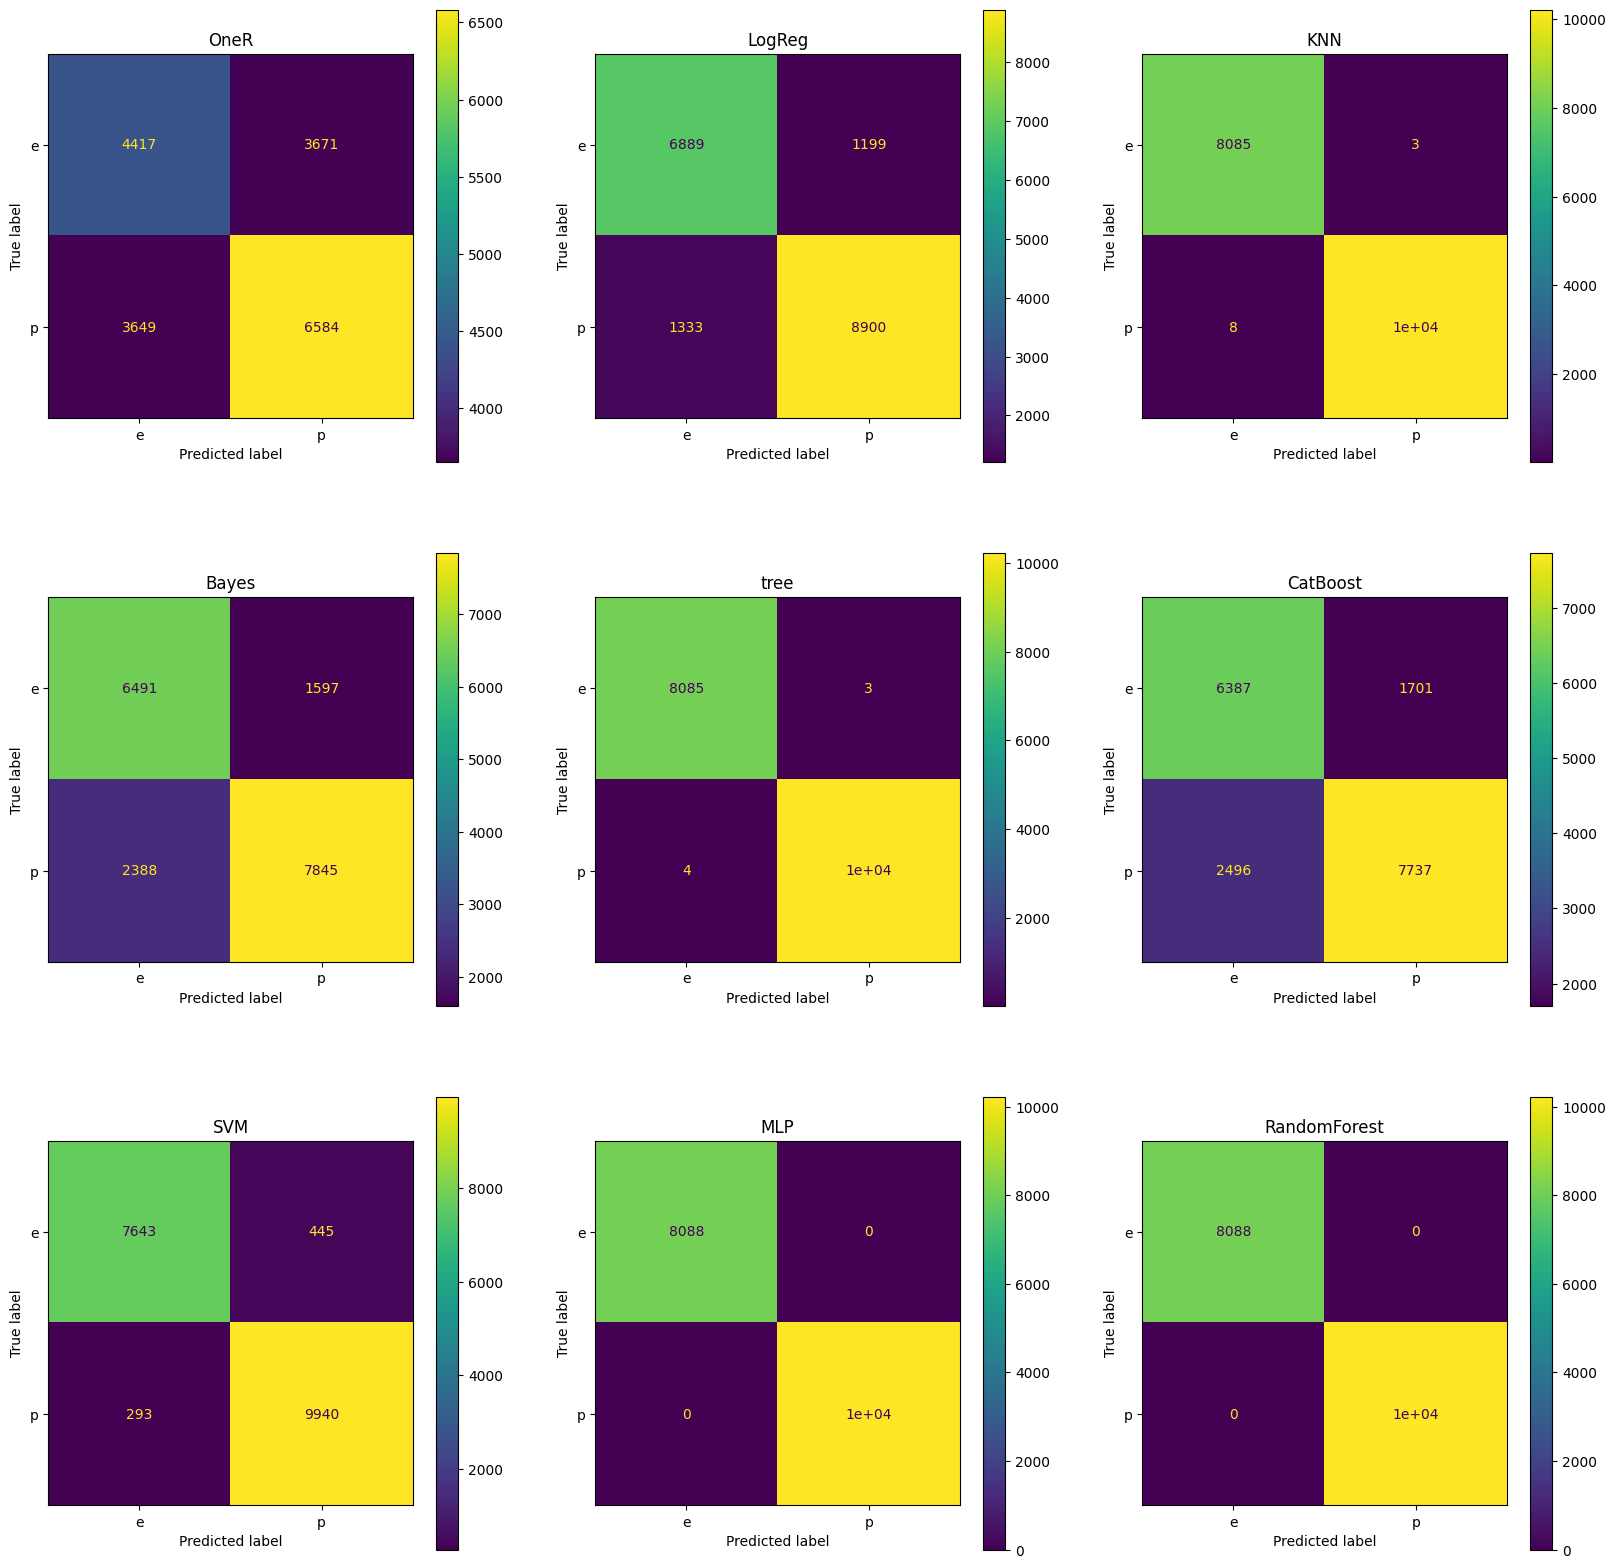

In [48]:
#confusion matrix
fig, ax = plt.subplots(3, 3, figsize=(20, 20))
counter = 0
for i in range(3):
    for j in range(3):
        name, model = list(models_dict.items())[counter]
        y_pred = model.predict(X_test.to_numpy()) if name == 'OneR' else model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
        ax[i][j].set_title(name)
        ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LE.classes_).plot(ax=ax[i][j])
        counter+=1

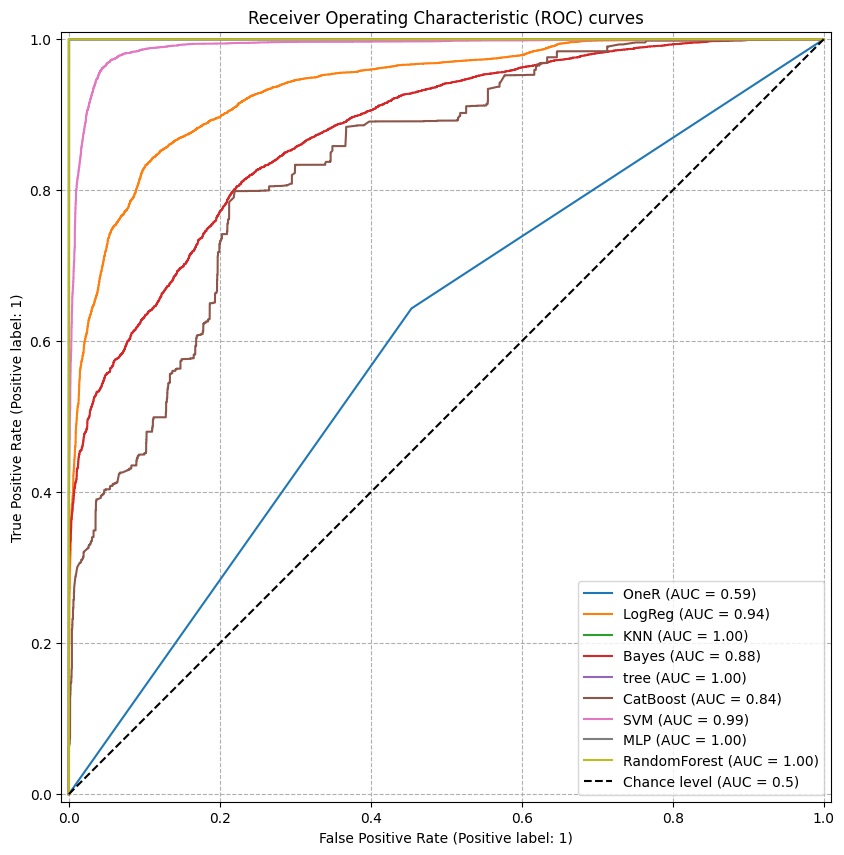

In [49]:
#roc auc curve
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for name, model in models_dict.items():
    if name == 'OneR':
        y_pred = model.predict(X_test.to_numpy())
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=name).plot(ax=ax) if name == 'OneR' else RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax, name=name)
ax.plot((0, 1), (0, 1), 
        label="Chance level (AUC = 0.5)",
        color="k",
        linestyle="--",)
ax.legend()
ax.set_title("Receiver Operating Characteristic (ROC) curves")
ax.grid(linestyle="--")

## 4. Исследование важности признаков

в этой части работы мне на голову упал кокос и мне захотелось исследовать признаки кетбуста, так как он кажется черным ящиком

In [78]:
!pip install tqdm

In [79]:
import catboost
import shap
from sklearn.feature_selection import RFE

In [80]:
cat = models_dict['CatBoost']

In [99]:
#признаки, которые являются значимыми (>0)
feature_importances_value = cat.feature_importances_[cat.feature_importances_ > 5]
feature_importances_name = np.array(cat.feature_names_)[cat.feature_importances_ > 5]
(feature_importances_name, feature_importances_value)

(array(['stem-height', 'stem-width', 'cap-shape_b', 'gill-spacing_d',
        'stem-surface_g', 'stem-surface_s', 'stem-color_w', 'ring-type_z'],
       dtype='<U22'),
 array([ 5.28310081, 21.73406797,  8.00095105, 15.07811082,  8.72501933,
         5.35829376,  8.20497329, 16.5288462 ]))

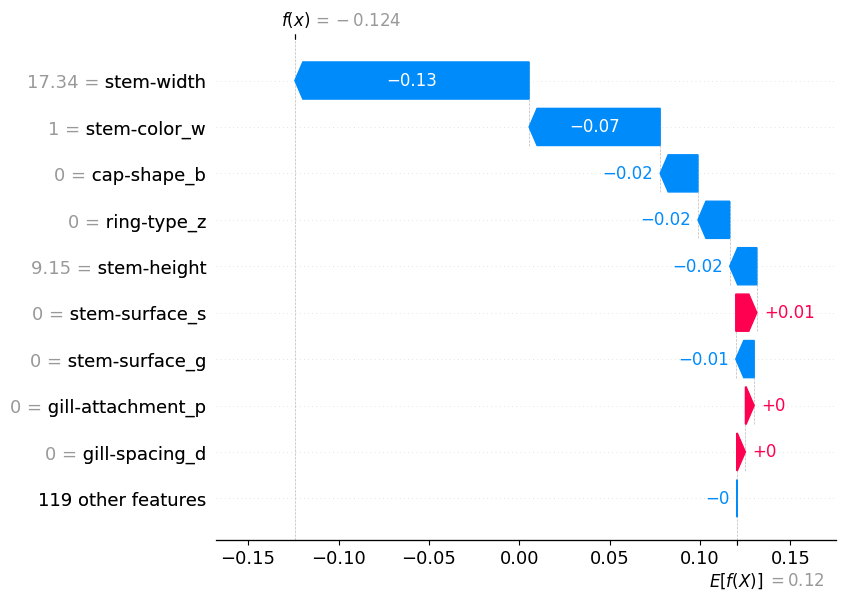

In [101]:
#посмотрим на фичи через shap
explainer = shap.Explainer(cat)
shap_values = explainer(X)

shap.plots.waterfall(shap_values[354])

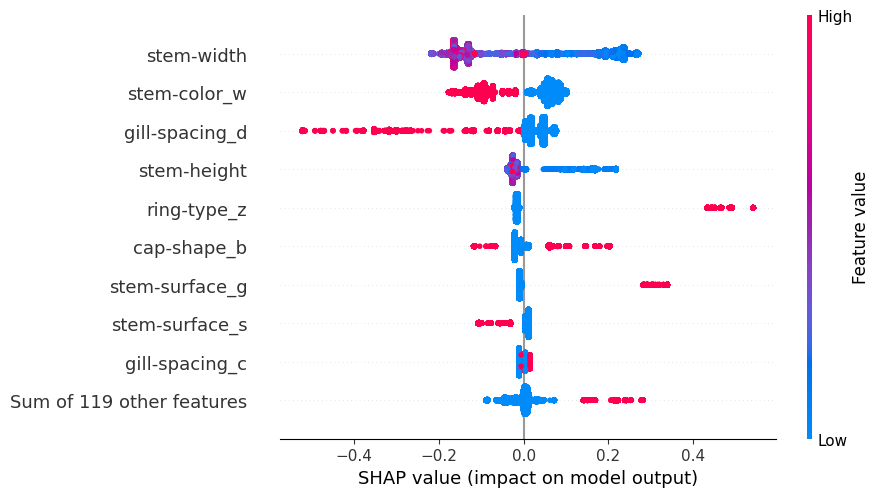

In [86]:
shap.plots.beeswarm(shap_values)

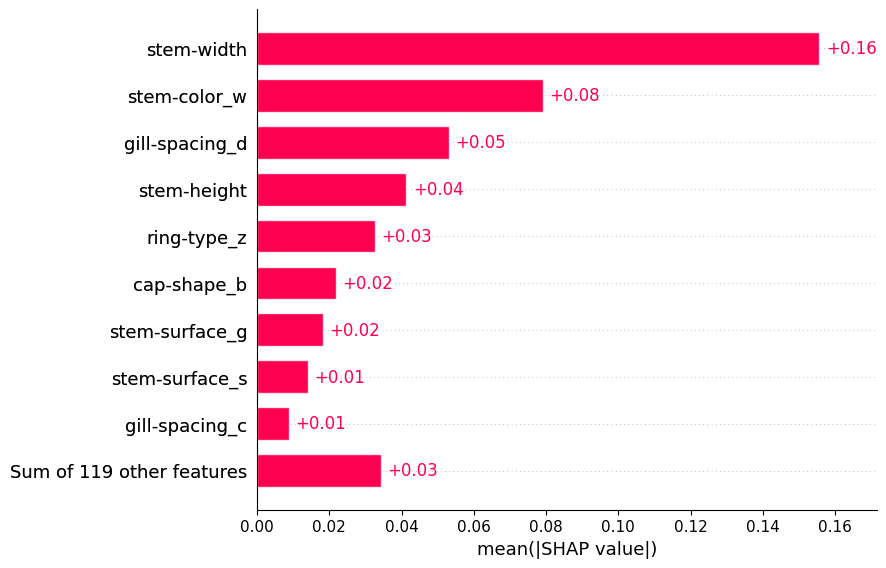

In [100]:
shap.plots.bar(shap_values)